In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
sns.set()
import warnings
warnings.filterwarnings("ignore")

In [60]:
class DataCollection:
    """
    get_data : Param:   companies: Companies shortname splitted with space.
                        start_date: Start date for the stock data.
                        end_date:  Close date for the stock data.
               Returns: df: Cleaned Dataframe consisting of Close prices of the provided companies.   
    
    preprocess_data : Param: df: Dataframe
                    Returns: df: Dataframe with no missing values. 
    """
    
    def __init__(self):
        pass
      
        
    def get_data(self, companies, start_date, end_date):
        """
        1. Scraping stock data from yahoo finance library
        2. Removing all other columns and keeping only Closing price.
        """
        df = pd.DataFrame()
        try:
            raw_data = yf.download(tickers=companies, start=start_date, end=end_date, 
                                        interval="1d", group_by = 'ticker', auto_adjust=True, threads=True)
            for company in companies.split():
                df[company+"_close"] = raw_data[company.upper()]["Close"]
            return self.preprocess_data(df)
        except Exception as exp:
            raise Exception
    
    def preprocess_data(self, df):
        """
        1. Removing dates from non-business days (Saturday and Sunday).
        2. Replacing missing values by front filling method.
        """
        df = df.asfreq('b')
        df = df.fillna(method="ffill")
        return df

    
if __name__ == "__main__":
    df = DataCollection().get_data(companies="msft aapl", start_date="2015-01-01", end_date="2021-01-01")
    size = int(len(df)*0.8)
    df_train, df_test = df.iloc[:size], df.iloc[size:]

[*********************100%***********************]  2 of 2 completed


In [61]:
class EDA:
    def __init__(self, df_train):
        self.df_train = df_train
    
    
    def white_noise_check(self):
        """
        Check for mean is 0, std is constant and no autocorelation.
        These plot might not be good visualization approach of autocorelation. 
        We can later use ACF or PACF to check for autocorelation parameter of white noises.
        """
        for df in self.df_train.columns:
            self.df_train[df+"_white_noise"] = np.random.normal(loc=self.df_train[df].mean(), scale=self.df_train[df].std(), 
                                                 size=len(df_train))
            df_train[df+"_white_noise"].plot(figsize=(15,5))
            plt.title(df+"_white_noise", size=20)
            plt.show()
            df_train[df].plot(figsize=(15,5))
            plt.show()
    
    
    def stationarity_check(self):
        """
        1. Stationarity test by David Dickey and Wanye Fuller known as agumented fuller
        2. Check for mean/std to be constant and for no seasonility.
        """
        for df in self.df_train.columns:
            ad_fuller = sts.adfuller(self.df_train[df])
            print("statistics for {}: {}".format(df,ad_fuller))
       
    
    def seasonality_check(self):
        """
        1. Additive Navie Decompostion for checking seasonality
        """
        for df in self.df_train.columns:
            additive_decomposition = seasonal_decompose(self.df_train[df], model="additive")
            additive_decomposition.plot()
            plt.show()

            
    def autocorelation_factor_check(self, lags):
        """
        1. ACF between different lags we are interested in
        lags=40: The last 40 period before the current one.
        zero=False: Ignores the current period value
        """
        for df in self.df_train.columns:
            sgt.plot_acf(self.df_train[df], lags=lags, zero=False)
            plt.title("ACF {}".format(df))
            plt.show()
            
            
    def partial_autocorelation_factor_check(self, lags):
        """
        1. PACF between different lags we are interested in.
        lags=40: The last 40 period before the current one.
        zero=False: Ignores the current period value
        method: Various methods are available.OLS is one of those i.e. Order of Least Squares
        """
        for df in self.df_train.columns:
            sgt.plot_pacf(self.df_train[df], lags=lags, zero=False, method=('ols'))
            plt.title("PACF {}".format(df))
            plt.show()
            
            
            
if __name__ == "__main__":
    eda = EDA(df_train)
    """
    Use these to check and understand the data more:
    1. eda.white_noise_check()
    2. eda.stationarity_check()
    3. eda.seasonality_check()
    4. eda.autocorelation_factor_check(lags=40)
    5. eda.partial_autocorelation_factor_check(lags=40)
    """
    

In [62]:
class Test:
    def __init__(self):
        pass
    
    def log_likelihood_test(self, model_list_1, model_list_2,index_of_model_list, DF):
        l1 = model_list_1[index_of_model_list].llf
        l2 = model_list_2[index_of_model_list].llf
        test_statistic = (2*(l2-l1))
        pvalue = chi2.sf(test_statistic, DF).round(3)
        return pvalue

In [63]:
class Model:
    def __init__(self, df_train):
        self.df_train = df_train
        
        
    def  auto_regression_model(self, order, display_summary):
        """
        order=(x,y): x= No. of past values(lags) we want to incorporate into the model
                     y= 0 if not taking any residuals into consideration, 1 if taking them into considerations
        """
        model_list = []
        for df in self.df_train.columns:
            ar_model = ARMA(self.df_train[df], order=order)
            result_of_ar_model = ar_model.fit()
            model_list.append(result_of_ar_model)
            if display_summary:
                print("\n\n\n\n"+df)
                print(result_of_ar_model.summary())
        return model_list
            
            
if __name__ == "__main__":
    model = Model(df_train)
    test = Test()
    """
    we can try out different orders. (1, 0), (2, 0), (3, 0), (4, 0) for all the given columns.
    Our goal here is to have a higher log likelihood ratio. And if we see the highest LLR value, take the lag before that. It will prevent overfitting.
    By observation, Seems like for column msft_close, we can consider lag of 4.
    While for column aapl_close,  we can consider lag of 3.
    """ 
    model_list_1 = model.auto_regression_model(order=(3, 0), display_summary=False)
    model_list_2 = model.auto_regression_model(order=(4, 0), display_summary=False)
    result = test.log_likelihood_test(model_list_1, model_list_2, index_of_model_list=1, DF=1)
    print(result)

0.736


But as in as we should not rely on AR model because we have a non stationary data.
Our best bet is transforming the dataset. An approach for solving this is using a concept known as returns.

In [64]:
df_returns = pd.DataFrame()
for df in df_train.columns:
    df_returns["{}_returns".format(df)] = df_train[df].pct_change(1).mul(100)
    df_returns = df_returns.iloc[1:]
df_returns

,msft_close_returns,aapl_close_returns
Date,,
2015-01-02,0.667399,-0.951261
2015-01-05,-0.919580,-2.817163
2015-01-06,-1.467702,0.009424
2015-01-07,1.270483,1.402244
2015-01-08,2.941820,3.842206
...,...,...
2019-10-14,-0.093079,-0.143957
2019-10-15,1.447535,-0.233162
2019-10-16,-0.819392,-0.403708


In [65]:
eda = EDA(df_returns)
eda.stationarity_check()

statistics for msft_close_returns: (-18.14054731815924, 2.491543102927782e-30, 4, 1246, {'1%': -3.4356090875394525, '5%': -2.863862410805964, '10%': -2.568006480268158}, 4353.41328264129)
statistics for aapl_close_returns: (-26.148764918455615, 0.0, 1, 1249, {'1%': -3.4355964295197743, '5%': -2.863856825923603, '10%': -2.5680035060041626}, 4542.01145584021)


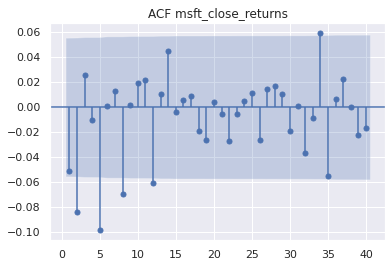

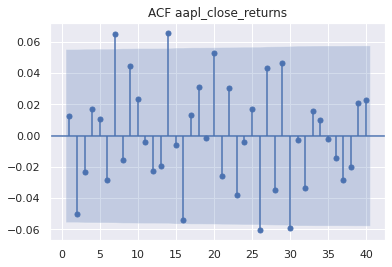

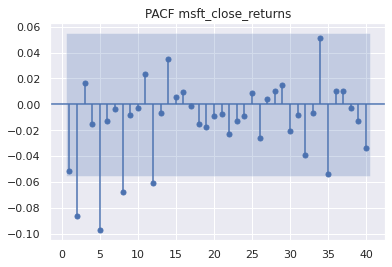

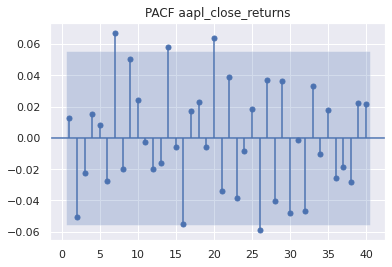

In [66]:
eda.autocorelation_factor_check(lags=40)
eda.partial_autocorelation_factor_check(lags=40)

Seems like the data has become stationary. Let check it out by fitting it to AR model.

In [70]:
model = Model(df_returns)
test = Test()
model_list_1 = model.auto_regression_model(order=(3, 0), display_summary=False)
model_list_2 = model.auto_regression_model(order=(4, 0), display_summary=True)
result = test.log_likelihood_test(model_list_1, model_list_2, index_of_model_list=1, DF=1)
print(result)





msft_close_returns
                              ARMA Model Results                              
Dep. Variable:     msft_close_returns   No. Observations:                 1251
Model:                     ARMA(4, 0)   Log Likelihood               -2244.987
Method:                       css-mle   S.D. of innovations              1.456
Date:                Sun, 15 Aug 2021   AIC                           4501.974
Time:                        23:26:43   BIC                           4532.765
Sample:                    01-02-2015   HQIC                          4513.549
                         - 10-18-2019                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1060      0.036      2.935      0.003       0.035       0.177
ar.L1.msft_close_returns    -0.0543      0.028     -1.920      0.0

Looks like lag value for msft must be 3 and for aapl must me 4.